In [7]:
import pandas as pd
from scipy.stats import wasserstein_distance
#import keras
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import energyflow as ef
from energyflow.archs import CNN, DNN
from sklearn.utils import class_weight, shuffle
import matplotlib.pyplot as plt

In [8]:
nFeat = 4
n_gen = 400000

# Load Data for Classification

In [9]:
# load real mc sample
innerdata_train = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_train_6var.npy")
X_mc_train = innerdata_train[:,1:nFeat+1]
print("shape of X_mc_train: ", X_mc_train.shape)
innerdata_val = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_val_6var.npy")
X_mc_val = innerdata_val[:,1:nFeat+1]
print("shape of X_mc_val: ", X_mc_val.shape)

# load generated bkg sample
# gen_SR = np.load("fake_SR_cbvae_6var_n400000_BestModels.npy")
fileNameNN = '/global/homes/a/agarabag/LHCO2020-cVAE/pre_trained_data/cBVAE-6var/gen_data/LHCO2020_cB-VAE_events_lr1en3_ConvF_SR.csv'
gen_SR = pd.read_csv(fileNameNN, delimiter = ' ', header=None, index_col=False)
gen_SR = gen_SR.to_numpy()
gen_SR = gen_SR[:,:nFeat]
print("shape of gen_SR: ", gen_SR.shape)
gen_SR_train = gen_SR[:int(n_gen/2)]
print("shape of gen_SR_train", gen_SR_train.shape)
gen_SR_val = gen_SR[int(n_gen/2):]
print("shape of gen_SR_val", gen_SR_val.shape)

# load test mc sample
innerdata_test = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_test_6var.npy")
innerdata_extrabkg_test = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_extrabkg_test_6var.npy")
innerdata_test = np.concatenate((innerdata_test, innerdata_extrabkg_test), axis=0)
X_mc_test = innerdata_test[:,1:nFeat+1]
print("shape of X_mc_test: ", X_mc_test.shape)

shape of X_mc_train:  (60000, 4)
shape of X_mc_val:  (60000, 4)
shape of gen_SR:  (400000, 4)
shape of gen_SR_train (200000, 4)
shape of gen_SR_val (200000, 4)
shape of X_mc_test:  (360000, 4)


[0.48882216 0.53541732 0.41433522 ... 0.2527045  0.37027949 0.82875061]
#############################


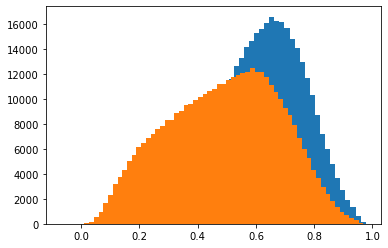

In [10]:
print(gen_SR[:,3])
print("#############################")
plt.hist(gen_SR[:,2], bins=60)
plt.hist(gen_SR[:,3], bins=60)
plt.show()

In [11]:
X_train_mc_and_gen = np.concatenate((X_mc_train, gen_SR_train), axis=0)
print("shape of training mc and data combination: ", X_train_mc_and_gen.shape)

X_val_mc_and_gen = np.concatenate((X_mc_val, gen_SR_val), axis=0)
print("shape of val mc and data combination: ", X_val_mc_and_gen.shape)

shape of training mc and data combination:  (260000, 4)
shape of val mc and data combination:  (260000, 4)


In [12]:
y_train_mc = np.ones(X_mc_train.shape[0])
print("shape of train_mc label: ", y_train_mc.shape)

y_train_gen = np.zeros(gen_SR_train.shape[0])
print("shape of train_gen label: ", y_train_gen.shape)

y_val_mc = np.ones(X_mc_val.shape[0])
print("shape of val_mc label: ", y_val_mc.shape)

y_val_gen = np.zeros(gen_SR_val.shape[0])
print("shape of val_gen label: ", y_val_gen.shape)

y_mc_test = innerdata_test[:,nFeat+3]
print("shape of mc_test label: ", y_mc_test.shape)


shape of train_mc label:  (60000,)
shape of train_gen label:  (200000,)
shape of val_mc label:  (60000,)
shape of val_gen label:  (200000,)
shape of mc_test label:  (360000,)


In [13]:
y_train_mc_and_gen = np.concatenate((y_train_mc, y_train_gen), axis=0)
print("shape of training mc and data label combination: ", y_train_mc_and_gen.shape)

y_val_mc_and_gen = np.concatenate((y_val_mc, y_val_gen), axis=0)
print("shape of val mc and data label combination: ", y_val_mc_and_gen.shape)

shape of training mc and data label combination:  (260000,)
shape of val mc and data label combination:  (260000,)


In [14]:
shuffle_seed = 42
X_train_mc_and_gen, y_train_mc_and_gen = shuffle(X_train_mc_and_gen, y_train_mc_and_gen, random_state = shuffle_seed)
X_val_mc_and_gen, y_val_mc_and_gen = shuffle(X_val_mc_and_gen, y_val_mc_and_gen, random_state = shuffle_seed)
X_mc_test, y_mc_test = shuffle(X_mc_test, y_mc_test, random_state = shuffle_seed)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_mc_and_gen)
#transform training dataset
X_train_mc_and_gen = scaler.transform(X_train_mc_and_gen)
# transform val dataset
X_val_mc_and_gen = scaler.transform(X_val_mc_and_gen)


In [16]:
# transform test dataset
X_mc_test = scaler.transform(X_mc_test)

In [11]:
# es = callbacks.EarlyStopping(monitor='loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
optimizer = Adam(lr=1e-5)
model = Sequential()
model.add(Dense(64, input_dim=nFeat, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = tf.keras.callbacks.History()
num_epoch=40
batch_size=128
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_mc_and_gen),y_train_mc_and_gen)
class_weights_dict = dict(enumerate(class_weights))

class CustomSaver(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save("/global/u2/a/agarabag/LHCO2020-cVAE/classifier_cbvae_6varInput_4varTrain/model_cbvae_4var_epoch{}.h5".format(epoch))

saver = CustomSaver()

In [11]:
learning_rates = [5e-3,1e-3,5e-4,1e-4,1e-5,1e-6,1e-7]
def fit_model(lrate):
    optimizer = Adam(lr=lrate)
    model = Sequential()
    model.add(Dense(64, input_dim=nFeat, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = tf.keras.callbacks.History()
    num_epoch=30
    batch_size=128
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_mc_and_gen),y_train_mc_and_gen)
    class_weights_dict = dict(enumerate(class_weights))
    class CustomSaver(callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            self.model.save("/global/u2/a/agarabag/LHCO2020-cVAE/classifier_cbvae_6varInput_4varTrain/model_cbvae_4var_epoch{0}_lrt{1}.h5".format(epoch, lrate))
    saver = CustomSaver()
    
    model.fit(X_train_mc_and_gen, y_train_mc_and_gen, 
        epochs=num_epoch,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        validation_data=(X_val_mc_and_gen, y_val_mc_and_gen), 
        shuffle=shuffle,
        verbose=1,callbacks=[history,saver])
    
    # plot learning curves
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.title('lrate='+str(lrate), pad=-50)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/global/homes/a/agarabag/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 260000 samples, validate on 260000 samples


2022-08-11 14:15:27.903171: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-11 14:15:27.970076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:b2:00.0
2022-08-11 14:15:27.970602: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-08-11 14:15:27.972269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-08-11 14:15:27.973857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-08-11 14:15:27.974409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-08-11 14:15:27.976378: I tensorflow/stream_executor/platfo

Epoch 1/30


2022-08-11 14:15:29.052511: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


260000/260000 [==============================] - 7s 27us/sample - loss: 0.6896 - acc: 0.6080 - val_loss: 0.6971 - val_acc: 0.6209
Epoch 2/30
260000/260000 [==============================] - 6s 25us/sample - loss: 0.6889 - acc: 0.6227 - val_loss: 0.6876 - val_acc: 0.5645
Epoch 3/30
260000/260000 [==============================] - 6s 24us/sample - loss: 0.6885 - acc: 0.6123 - val_loss: 0.6908 - val_acc: 0.5658
Epoch 4/30
260000/260000 [==============================] - 6s 25us/sample - loss: 0.6882 - acc: 0.6022 - val_loss: 0.6829 - val_acc: 0.6072
Epoch 5/30
260000/260000 [==============================] - 6s 25us/sample - loss: 0.6880 - acc: 0.6072 - val_loss: 0.6909 - val_acc: 0.6047
Epoch 6/30
260000/260000 [==============================] - 6s 25us/sample - loss: 0.6880 - acc: 0.6027 - val_loss: 0.7003 - val_acc: 0.5613
Epoch 7/30
260000/260000 [==============================] - 6s 25us/sample - loss: 0.6879 - acc: 0.6025 - val_loss: 0.6967 - val_acc: 0.6026
Epoch 8/30
260000/260000

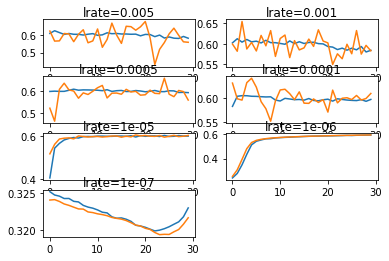

In [12]:
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(learning_rates[i])
    
plt.show()

In [24]:
model.fit(X_train_mc_and_gen, y_train_mc_and_gen, 
        epochs=num_epoch,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        validation_data=(X_val_mc_and_gen, y_val_mc_and_gen), 
        shuffle=shuffle,
        verbose=1,callbacks=[history,saver])

Train on 260000 samples, validate on 260000 samples
Epoch 1/40
260000/260000 [==============================] - 8s 31us/sample - loss: 0.6915 - acc: 0.5748 - val_loss: 0.6912 - val_acc: 0.5785
Epoch 2/40
260000/260000 [==============================] - 7s 28us/sample - loss: 0.6901 - acc: 0.5797 - val_loss: 0.6890 - val_acc: 0.5868
Epoch 3/40
260000/260000 [==============================] - 7s 28us/sample - loss: 0.6895 - acc: 0.5835 - val_loss: 0.6872 - val_acc: 0.5938
Epoch 4/40
260000/260000 [==============================] - 7s 28us/sample - loss: 0.6892 - acc: 0.5874 - val_loss: 0.6879 - val_acc: 0.5922
Epoch 5/40
260000/260000 [==============================] - 7s 29us/sample - loss: 0.6889 - acc: 0.5915 - val_loss: 0.6897 - val_acc: 0.5858
Epoch 6/40
260000/260000 [==============================] - 7s 28us/sample - loss: 0.6888 - acc: 0.5902 - val_loss: 0.6899 - val_acc: 0.5861
Epoch 7/40
260000/260000 [==============================] - 7s 29us/sample - loss: 0.6886 - acc: 0.590

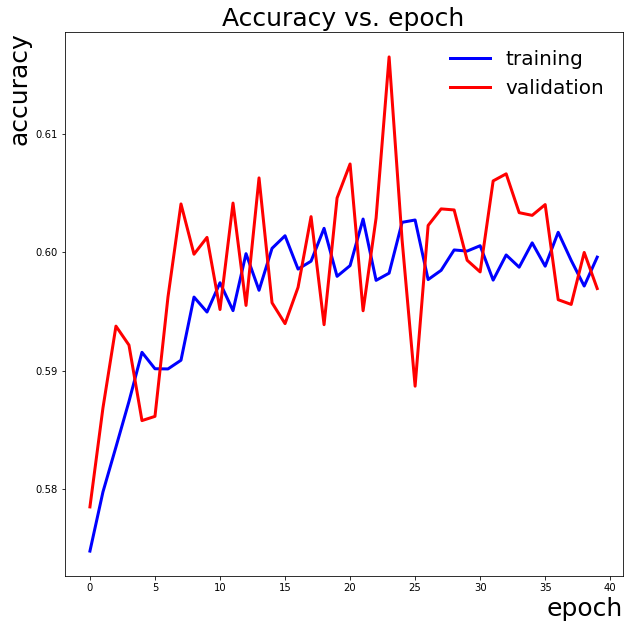

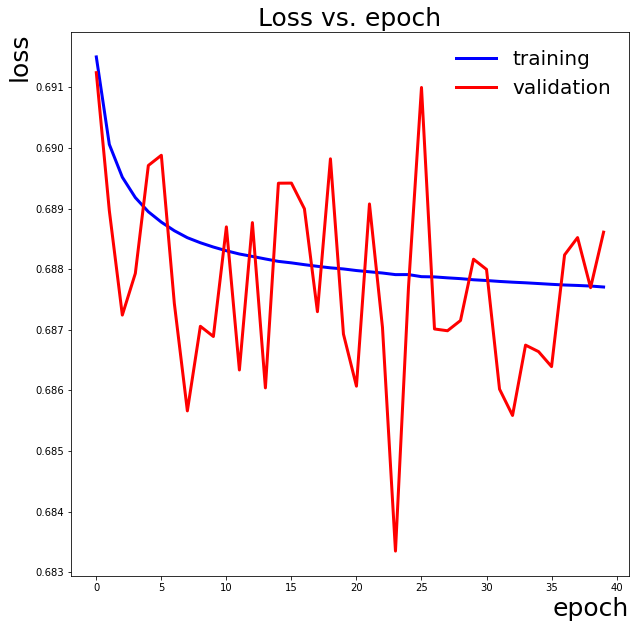

In [34]:
"""
Accuracy of training and validating
"""
fig1, ax1 = plt.subplots(1,1, figsize=(10,10))

# plt.plot(np.arange(0,num_epoch), history.history['acc'], label='training',c='blue',linewidth = 3)
# plt.plot(np.arange(0,num_epoch), history.history['val_acc'], label='validation',c='red',linewidth = 3)
plt.plot(history.history['acc'], label='training',c='blue',linewidth = 3)
plt.plot(history.history['val_acc'], label='validation',c='red',linewidth = 3)

plt.title("Accuracy vs. epoch", fontsize=25)

ax1.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax1.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()


"""
Loss of training and validating
"""

fig2, ax2 = plt.subplots(1,1, figsize=(10,10))

plt.plot(np.arange(0,num_epoch), history.history['loss'], label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,num_epoch), history.history['val_loss'], label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax2.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax2.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()

In [26]:
num_models = 10
idx_best_models = np.argpartition(history.history['val_loss'], num_models)[:num_models]

Train_Predictions = []
Val_Predictions = []
Test_Predictions = []
for idx in idx_best_models:
    model_temp = keras.models.load_model("/global/u2/a/agarabag/LHCO2020-cVAE/classifier_cbvae_6varInput_4varTrain/model_cbvae_4var_epoch"+str(idx)+".h5")
    Train_Predictions.append(model_temp.predict(X_train_mc_and_gen))
    Val_Predictions.append(model_temp.predict(X_val_mc_and_gen))
    Test_Predictions.append(model_temp.predict(X_mc_test))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
predict_train = np.mean(Train_Predictions, axis=0)
print(predict_train.shape)

predict_val = np.mean(Val_Predictions, axis=0)
print(predict_val.shape)

predict_test = np.mean(Test_Predictions, axis=0)
np.save("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_pytorch.npy", predict_test)
print(predict_test.shape)

(260000, 1)
(260000, 1)
(360000, 1)


In [28]:


auc_train = roc_auc_score(y_train_mc_and_gen, predict_train)
roc_train = roc_curve(y_train_mc_and_gen, predict_train)

auc_val = roc_auc_score(y_val_mc_and_gen, predict_val)
roc_val = roc_curve(y_val_mc_and_gen, predict_val)

auc_test = roc_auc_score(y_mc_test, predict_test)
roc_test = roc_curve(y_mc_test, predict_test)

In [54]:
FalsePositive_test = roc_test[0]
TruePositive_test = roc_test[1]

pass_cut = np.where(FalsePositive_test>1.8382353*1e-5)
FalsePositive_test, TruePositive_test = FalsePositive_test[pass_cut], TruePositive_test[pass_cut]

FalsePositive_test.sort()
TruePositive_test.sort()

In [55]:
fpr_nonzero = np.delete(FalsePositive_test, np.argwhere(FalsePositive_test == 0))
tpr_nonzero = np.delete(TruePositive_test, np.argwhere(TruePositive_test == 0))


print(FalsePositive_test, "########", TruePositive_test, "#######", fpr_nonzero, "########", tpr_nonzero)
print(len(fpr_nonzero[2:]), len(tpr_nonzero))

[9.41176471e-05 9.41176471e-05 5.14705882e-04 ... 9.98888235e-01
 9.98894118e-01 1.00000000e+00] ######## [0.e+00 5.e-05 5.e-05 ... 1.e+00 1.e+00 1.e+00] ####### [9.41176471e-05 9.41176471e-05 5.14705882e-04 ... 9.98888235e-01
 9.98894118e-01 1.00000000e+00] ######## [5.e-05 5.e-05 1.e-04 ... 1.e+00 1.e+00 1.e+00]
66989 66990


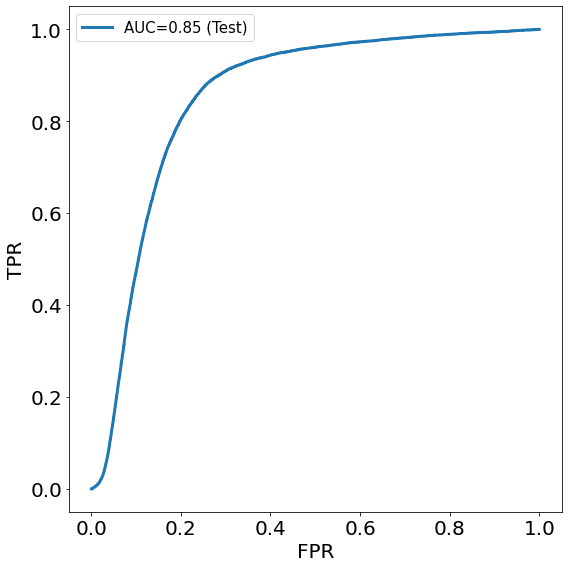

In [56]:
"""
Generate ROC figure
"""
fig3, ax3 = plt.subplots(1,1, figsize=(8,8))

plt.plot(FalsePositive_test, TruePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

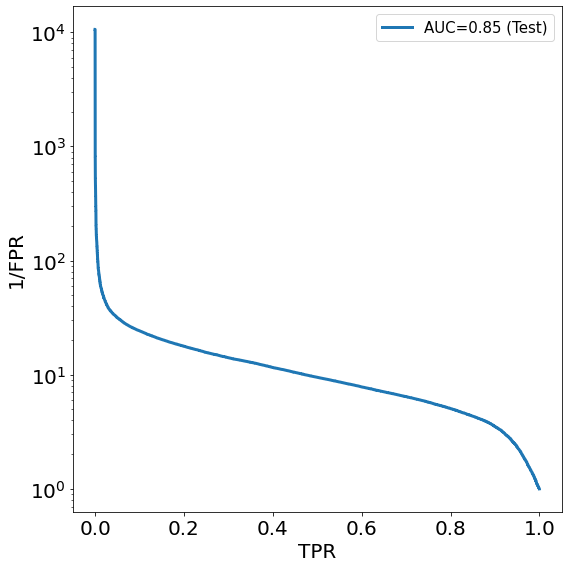

In [57]:
"""
Generate ROC figure
"""
fig5, ax5 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, 1/FalsePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)
plt.yscale("log")
plt.ylabel("1/FPR",fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


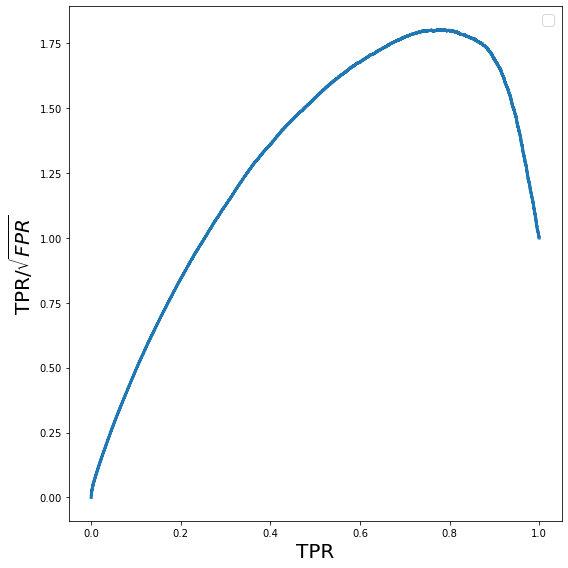

In [58]:
"""
Generate SIC figure
"""
fig4, ax4 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, TruePositive_test/np.sqrt(FalsePositive_test), linewidth = 3, linestyle="-")
# plt.plot(tpr_nonzero, tpr_nonzero/np.sqrt(fpr_nonzero[2:]), linewidth = 3, linestyle="-")


ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'DNN scores (test)')

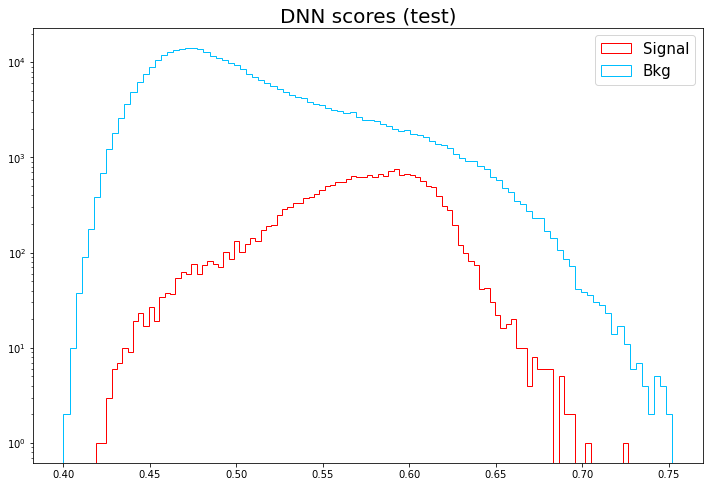

In [59]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))

is_sig = np.where(y_mc_test==1)
is_bkg = np.where(y_mc_test==0)

plt.hist(predict_test[is_sig], bins=100, stacked=False, histtype='step', color="red", label='Signal')
plt.hist(predict_test[is_bkg], bins=100, stacked=False, histtype='step', color="deepskyblue", label='Bkg')

plt.yscale('log')
plt.legend(loc="upper right", fontsize=15)
plt.title('DNN scores (test)', fontsize=20)

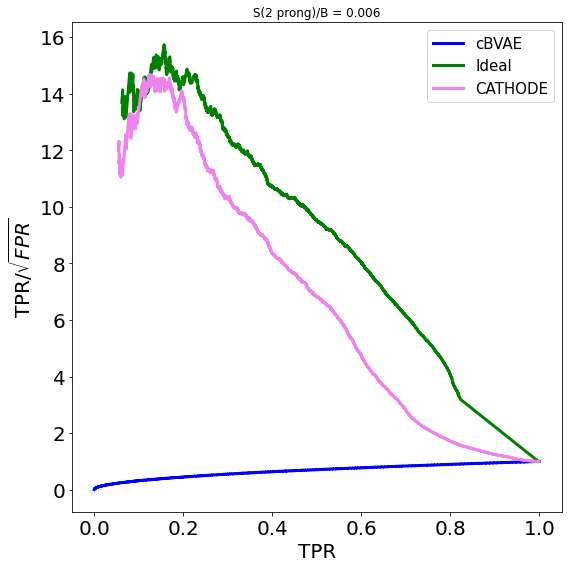

In [17]:
"""
Generate SIC figure comparison
"""
fig8, ax8 = plt.subplots(1,1, figsize=(8,8))

predict_2p_cbvae = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_pytorch.npy")
predict_2p_ideal = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_ideal_6varInput_4varTrain.npy")
predict_2p_cath = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cathode_4var.npy")

roc_2p_cbvae = roc_curve(y_mc_test, predict_2p_cbvae)
roc_2p_ideal = roc_curve(y_mc_test, predict_2p_ideal)
roc_2p_cath = roc_curve(y_mc_test, predict_2p_cath[:,1])

fpr_2p_cbvae, tpr_2p_cbvae = roc_2p_cbvae[0], roc_2p_cbvae[1]
fpr_2p_ideal, tpr_2p_ideal = roc_2p_ideal[0], roc_2p_ideal[1]
fpr_2p_cath, tpr_2p_cath = roc_2p_cath[0], roc_2p_cath[1]

idx_2p_cbvae = np.where(fpr_2p_cbvae>1.8382353*1e-5)
idx_2p_ideal = np.where(fpr_2p_ideal>1.8382353*1e-5)
idx_2p_cath = np.where(fpr_2p_cath>1.8382353*1e-5)

fpr_2p_cbvae, tpr_2p_cbvae = fpr_2p_cbvae[idx_2p_cbvae], tpr_2p_cbvae[idx_2p_cbvae]
fpr_2p_ideal, tpr_2p_ideal = fpr_2p_ideal[idx_2p_ideal], tpr_2p_ideal[idx_2p_ideal]
fpr_2p_cath, tpr_2p_cath = fpr_2p_cath[idx_2p_cath], tpr_2p_cath[idx_2p_cath]

plt.plot(tpr_2p_cbvae, tpr_2p_cbvae/np.sqrt(fpr_2p_cbvae), linewidth = 3, linestyle="-", color="blue", label="cBVAE")
plt.plot(tpr_2p_ideal, tpr_2p_ideal/np.sqrt(fpr_2p_ideal), linewidth = 3, linestyle="-", color="green", label="Ideal")
plt.plot(tpr_2p_cath, tpr_2p_cath/np.sqrt(fpr_2p_cath), linewidth = 3, linestyle="-", color="violet", label="CATHODE")

ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(2 prong)/B = 0.006")
plt.tight_layout()

plt.show()

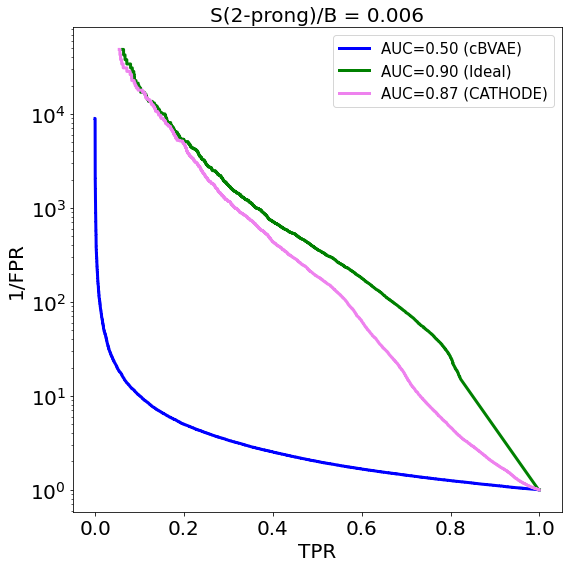

In [19]:
"""
Generate ROC figure comparison
"""
fig9, ax9 = plt.subplots(1,1, figsize=(8,8))

auc_2p_cbvae = roc_auc_score(y_mc_test, predict_2p_cbvae)
auc_2p_ideal = roc_auc_score(y_mc_test, predict_2p_ideal)
auc_2p_cath = roc_auc_score(y_mc_test, predict_2p_cath[:,1])

plt.plot(tpr_2p_cbvae, 1/fpr_2p_cbvae, linewidth = 3, linestyle="-", color="blue", label='AUC={0:.2f} (cBVAE)'.format(auc_2p_cbvae))
plt.plot(tpr_2p_ideal, 1/fpr_2p_ideal, linewidth = 3, linestyle="-", color="green", label='AUC={0:.2f} (Ideal)'.format(auc_2p_ideal))
plt.plot(tpr_2p_cath, 1/fpr_2p_cath, linewidth = 3, linestyle="-", color="violet", label='AUC={0:.2f} (CATHODE)'.format(auc_2p_cath))

ax9.tick_params(axis='x', labelsize=20)
ax9.tick_params(axis='y', labelsize=20)
plt.ylabel('1/FPR',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(2-prong)/B = 0.006", fontsize=20)
plt.yscale("log")
plt.tight_layout()

plt.show()